In [17]:
import os
import cv2
import image_operations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
import joblib

classes = ['Negative for intraepithelial lesion', 'ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'SCC']
base_dir = ''

all_image_paths = []

# Coleta todos os endereços das imagens
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    for image_name in os.listdir(class_dir):
        if image_name.endswith('.png') or image_name.endswith('.jpg'):  # Filtrando por arquivos de imagem
            image_path = os.path.join(class_dir, image_name)
            all_image_paths.append(image_path)

# Cria um dicionário de dados para armazenar os valores de Hu, o id e a classe de cada imagem
hu_values = {"id":[],
              "Hu_gray":[],
              "Hu_H":[],
              "Hu_S":[],
              "Hu_V":[],
              "Label":[]}

# Preenche os dados do dicionário para todas as imagens do dataset
for image in all_image_paths:
    hu_gray, hu_h, hu_s, hu_v = image_operations.get_hu_moments_model(cv2.imread(image))
    image_split = image.split("\\")
    image_label = image_split[0]
    image_id = image_split[1].split(".")[0]
    hu_values["id"].append(image_id)
    hu_values["Hu_gray"].append(hu_gray)
    hu_values["Hu_H"].append(hu_h)
    hu_values["Hu_S"].append(hu_s)
    hu_values["Hu_V"].append(hu_v)
    hu_values["Label"].append(image_label)
    
# Formata os dados separando cada valor de Hu em uma coluna diferente
df_model = pd.DataFrame(hu_values)
for col in [i for i in df_model.columns if "Hu" in i]:
    n_cols = [col+str(j) for j in range(1, 8)]
    df_model[n_cols] = df_model[col].tolist()
    df_model = df_model.drop(columns=col)

df_model = df_model.set_index("id")
df_model["Label"] = df_model["Label"].replace({
    "Negative for intraepithelial lesion": "NFIL",
    "ASC-H": "ASC-H",
    "ASC-US": "ASC-US",
    "HSIL": "HSIL",
    "LSIL": "LSIL",
    "SCC": "SCC"
})

# Randomiza a ordem dos dados e os separa em treino e teste com a proporção 4:1
X = df_model.drop(columns="Label")
y = df_model["Label"]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=674310)

# Mostra a disposição dos dados
X_train.describe()

,Hu_gray1,Hu_gray2,Hu_gray3,Hu_gray4,Hu_gray5,Hu_gray6,Hu_gray7,Hu_H1,Hu_H2,Hu_H3,...,Hu_S5,Hu_S6,Hu_S7,Hu_V1,Hu_V2,Hu_V3,Hu_V4,Hu_V5,Hu_V6,Hu_V7
count,9227.000000,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9227.000000,9.227000e+03,9.227000e+03,...,9.227000e+03,9.227000e+03,9.227000e+03,9227.000000,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03
mean,0.001165,3.688571e-06,4.067648e-07,3.787828e-07,9.069871e-10,1.834892e-08,-1.901558e-11,0.002920,1.557842e-08,6.904479e-11,...,1.614365e-08,6.376649e-07,-3.503371e-11,0.000808,3.261946e-07,4.978621e-09,4.333556e-09,3.718542e-14,7.198163e-11,-1.143760e-15
std,0.002316,8.741765e-05,3.096965e-05,2.985203e-05,8.650911e-08,1.499085e-06,1.806113e-09,0.000497,2.546780e-08,1.211818e-10,...,8.359955e-07,2.308650e-05,3.718492e-09,0.000767,1.264536e-05,2.239315e-07,1.935058e-07,2.536874e-12,4.736212e-09,8.849083e-14
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-7.402784e-10,-3.475966e-09,-1.734702e-07,0.001986,3.641856e-13,7.233503e-16,...,-2.742582e-07,-3.361707e-06,-2.344801e-07,0.000649,0.000000e+00,0.000000e+00,0.000000e+00,-8.926575e-13,-3.131278e-10,-8.239703e-12
25%,0.000696,8.269438e-12,2.993536e-15,3.009311e-14,-3.441289e-25,-3.937269e-17,-1.004645e-25,0.002467,2.431971e-09,9.679445e-12,...,-2.828395e-18,-5.918606e-13,-1.603778e-16,0.000654,0.000000e+00,0.000000e+00,0.000000e+00,-4.015091e-28,-5.393752e-19,-2.860162e-30
50%,0.000759,8.313716e-10,8.122064e-13,4.992762e-13,-6.256319e-30,-8.734230e-20,0.000000e+00,0.002958,7.291994e-09,3.086829e-11,...,2.827719e-18,1.343416e-12,0.000000e+00,0.000669,2.389783e-12,8.404630e-16,7.366274e-15,0.000000e+00,-1.547205e-25,0.000000e+00
75%,0.000981,1.433887e-08,2.033660e-11,9.979503e-12,2.315462e-26,1.207740e-20,1.117513e-25,0.003308,1.882384e-08,8.254445e-11,...,3.366294e-15,1.466084e-10,1.492593e-16,0.000727,7.212634e-10,7.954832e-13,3.446160e-13,0.000000e+00,0.000000e+00,2.223833e-30
max,0.075995,5.722733e-03,2.961244e-03,2.857352e-03,8.309751e-06,1.432489e-04,6.248772e-10,0.004498,6.458906e-07,4.340255e-09,...,7.271093e-05,1.857071e-03,1.974296e-07,0.035804,1.095255e-03,1.926094e-05,1.404942e-05,2.311055e-10,4.385767e-07,2.597431e-13


In [18]:
# Mostra a proporção dos valores das classes
print(y_train.value_counts(normalize=True), y_train.value_counts(), y_test.value_counts())

Label
NFIL      0.588707
HSIL      0.146201
LSIL      0.118240
ASC-H     0.079332
ASC-US    0.052672
SCC       0.014848
Name: proportion, dtype: float64 Label
NFIL      5432
HSIL      1349
LSIL      1091
ASC-H      732
ASC-US     486
SCC        137
Name: count, dtype: int64 Label
NFIL      1347
HSIL       354
LSIL       269
ASC-H      193
ASC-US     120
SCC         24
Name: count, dtype: int64


In [19]:
# Treina o modelo aplicando um balanceamento automatico no peso das classes
svm = SVC(class_weight={'NFIL': 0.3, 'LSIL': 1.4, 'ASC-H': 1.8, 'HSIL': 1.1, 'ASC-US': 2.5, 'SCC': 5}, C=10, kernel='rbf', gamma='scale')
svm.fit(X_train, y_train)

SVC(C=10,
    class_weight={'ASC-H': 1.8, 'ASC-US': 2.5, 'HSIL': 1.1, 'LSIL': 1.4,
                  'NFIL': 0.3, 'SCC': 5})

0.6207195491980928


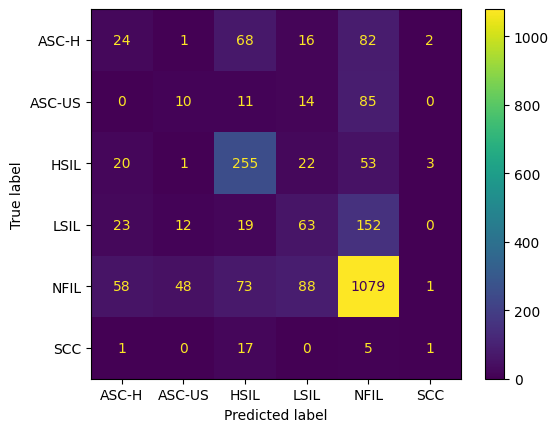

In [20]:
# Gera a matriz de confusão e a acurácia do modelo
labels = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'NFIL', 'SCC']

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, svm.predict(X_test)), display_labels=labels).plot()
y_pred = svm.predict(X_test)
print(accuracy_score(y_test, y_pred))

In [21]:
# Armazena o variável do modelo em um arquivo para ser acessado pela interface
joblib_file = "modelo_raso.pkl"
joblib.dump(svm, joblib_file)

['modelo_raso.pkl']